# Generate Ensemble graphs from individual causal networks

## Imports

In [1]:
import os
import warnings
warnings.filterwarnings("ignore") # Ignore warnings while loading 
import numpy as np
from iris import Constraint
from matplotlib import pyplot as plt
import utils as fk
from tigramite import plotting as tp
from glob import glob
import pickle
import pandas as pd
import math


## Load saved dictionary containing PCMCI+ results

In [2]:
pic= pickle.load(open('Results_DIR/OBS_CMIP6_valplink_dict.pickle', "rb"))

#### For every link, find the number of ensemble members to find such link

In [3]:
var_names=['$AMV$','$PNA$','$PDV$','$PSA1$']
N=4
max_timelag=15
dict_links={}
for regime in pic['OBS'].keys():
    dict_links[regime]={}
    for model in pic.keys():
        if model != 'OBS':
            dict_links[regime][model]={}
            for i in range (0, N):
                for j in range (0, N): 
                    if i != j:
                        link=var_names[i] + ' to ' + var_names[j]
                        count=0
                        nr_ens=len(pic[model].keys())
                        dict_links[regime][model][link]={'val_list':[],'lag_list':[]}
                        for em in pic[model].keys():
                            if len(pic[model][em][regime]) == 0: 
                                flag=1
                                #print('regime: '+regime+ ' too short: PCMCI+ failed')
                            else:
                                for lag in range (0, (max_timelag +1)):
                                    if pic[model][em][regime][2][i,j,lag] != '':
                                        count += 1
                                        dict_links[regime][model][link]['val_list'].append(pic[model][em][regime][0][i,j,lag])
                                        dict_links[regime][model][link]['lag_list'].append(lag)
                                        #dict_links[model][link]=[valist,laglist,fraction]
                                    else:
                                        pass
                                        #print('list indices must be integers or slices, not str', regime, em, model)
                        #print('count links : ' + str(count))
                        dict_links[regime][model][link]['fraction']=count/nr_ens

#### Compute mean lag and mean MCI

In [4]:
for regime in dict_links.keys():
    for model in dict_links[regime].keys():
        for link in dict_links[regime][model].keys():
            #print(model, regime)
            dict_links[regime][model][link]['mean_mci']= np.tanh(np.mean(np.arctanh(dict_links[regime][model][link]['val_list'])))
            dict_links[regime][model][link]['mean_lag']= np.mean(dict_links[regime][model][link]['lag_list'])

#### Make new val, link and link_width matrices

In [5]:
for regime in dict_links.keys():
    for model in dict_links[regime].keys():
        new_link_matrix=np.empty(
            pic['OBS']['No_mask'][2].shape,
            dtype='<U3',
            #order='C'
           )
        new_val_matrix=np.zeros(
            pic['OBS']['No_mask'][0].shape,
            dtype=float,
            #order='C'
           )
        new_link_width=np.zeros(
            pic['OBS']['No_mask'][0].shape,
            dtype=float,
            #order='C'
           )
        for i in range(0,N):
            for j in range(0,N):
                if i != j: 
                    if dict_links[regime][model][str(var_names[i]+' to '+var_names[j])]['fraction'] > 0.0:
         
                        round_lag=round(dict_links[regime][model][str(var_names[i]+' to '+var_names[j])]['mean_lag']) #math.floor
                        
                        if round_lag == 0:   # make consistent lag-zero links
                            new_link_matrix[i][j][0] = 'o-o'
                            new_link_matrix[j][i][0] = 'o-o'
                            
                            new_val_matrix[i][j][0]  = dict_links[regime][model][str(var_names[i]+' to '+var_names[j])]['mean_mci']
                            new_val_matrix[j][i][0]  = dict_links[regime][model][str(var_names[i]+' to '+var_names[j])]['mean_mci']
                            
                            new_link_width[i][j][0]  = dict_links[regime][model][str(var_names[i]+' to '+var_names[j])]['fraction']
                            new_link_width[j][i][0]  = dict_links[regime][model][str(var_names[i]+' to '+var_names[j])]['fraction']
                        else:                            
                            new_link_matrix[i][j][round_lag] = '-->'         #pic['OBS']['No_mask']['link_matrix'][0,0,1]
                            new_val_matrix[i][j][round_lag]  = dict_links[regime][model][str(var_names[i]+' to '+var_names[j])]['mean_mci']
                            new_link_width[i][j][round_lag]  = dict_links[regime][model][str(var_names[i]+' to '+var_names[j])]['fraction']

                    else:
                        flag=2
                        #print('No link: %s during %s for %s' % (str(var_names[i]+' to '+var_names[j]),regime,model))
        dict_links[regime][model]['mean_val_matrix'] = new_val_matrix
        dict_links[regime][model]['mean_link_matrix'] = new_link_matrix
        dict_links[regime][model]['link_width'] = new_link_width



In [6]:
with open('Results_DIR/ensemble_links_dict.pickle', 'wb') as handle:
    pickle.dump(dict_links, handle, protocol=pickle.HIGHEST_PROTOCOL)

Successfully created the directory Results_DIR/Ensemble_causal_graphs/


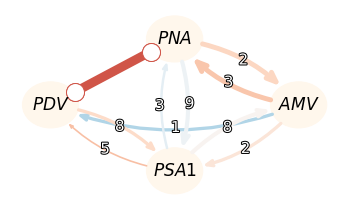

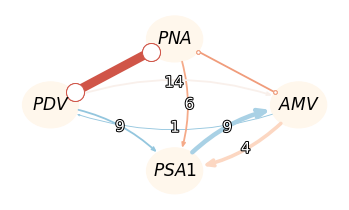

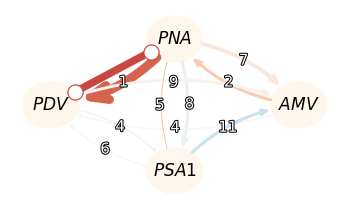

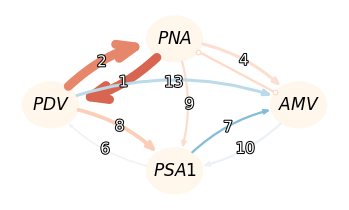

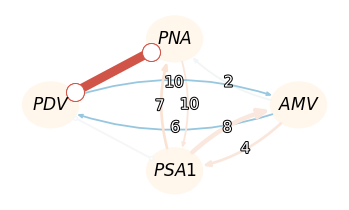

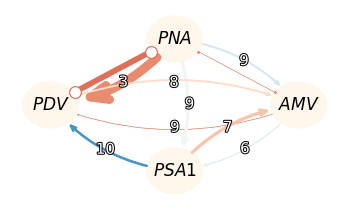

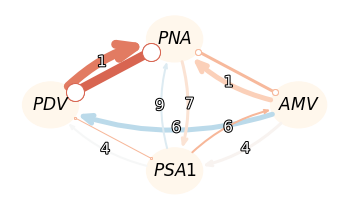

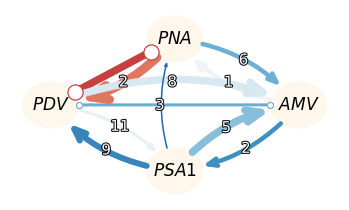

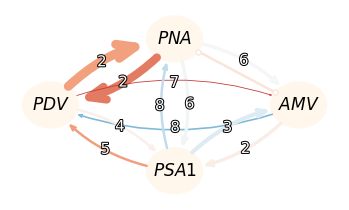

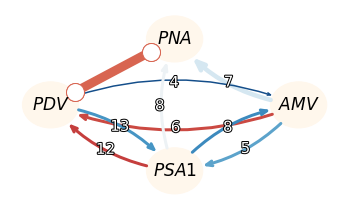

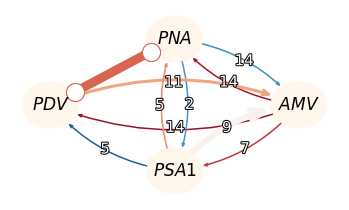

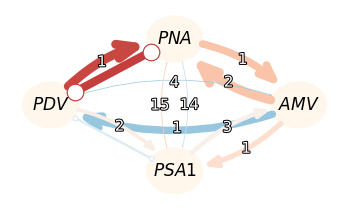

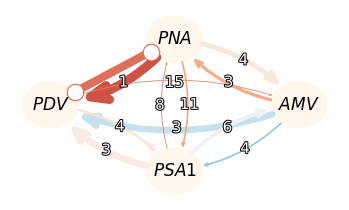

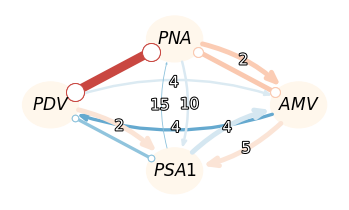

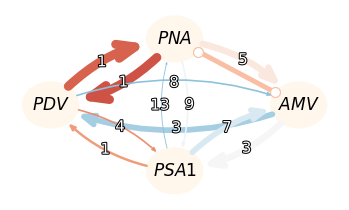

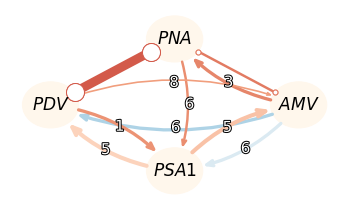

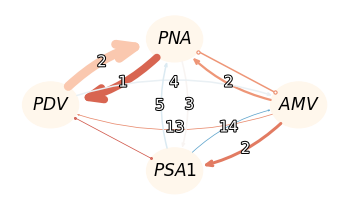

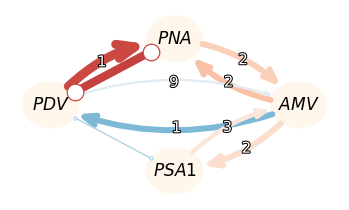

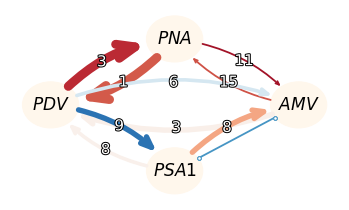

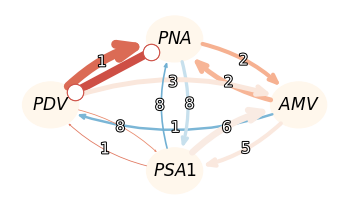

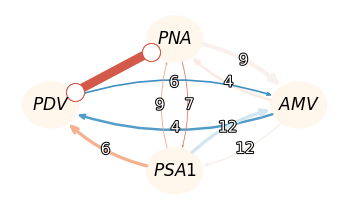

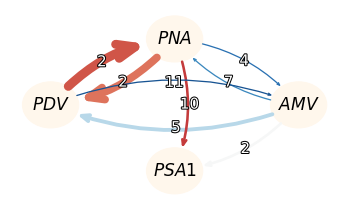

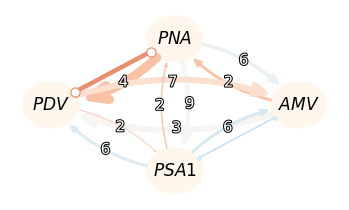

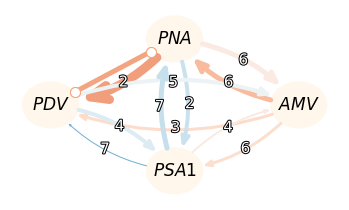

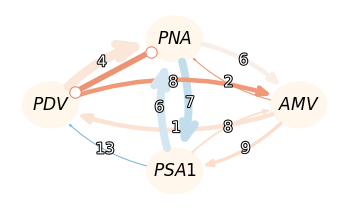

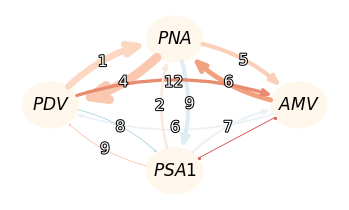

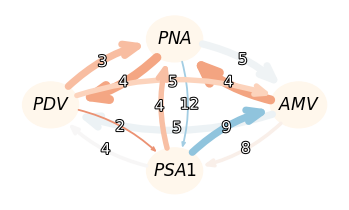

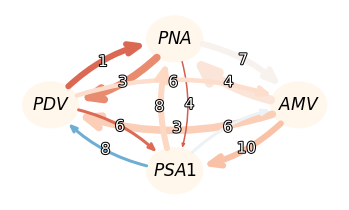

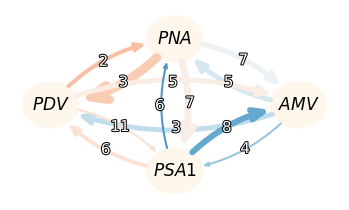

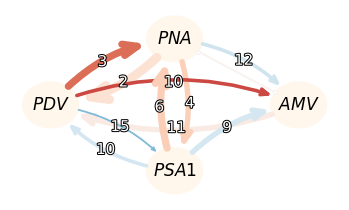

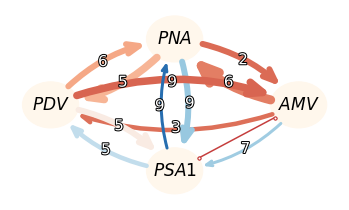

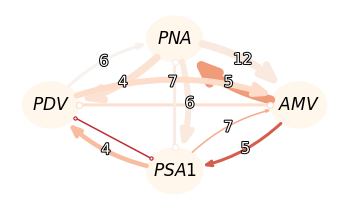

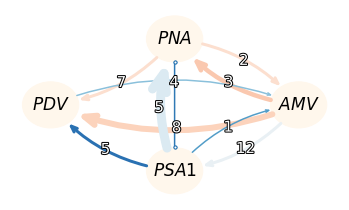

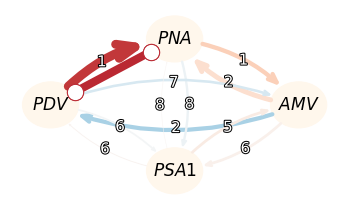

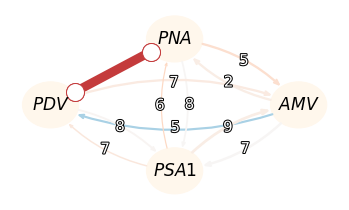

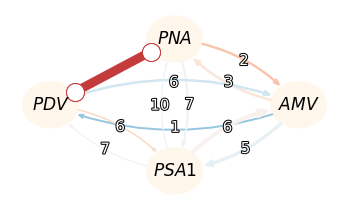

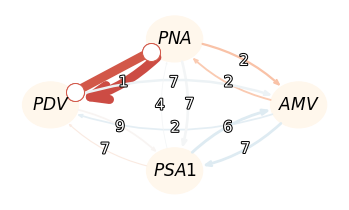

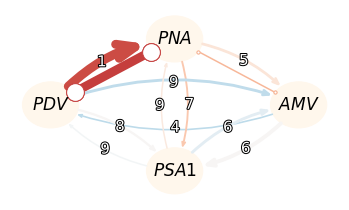

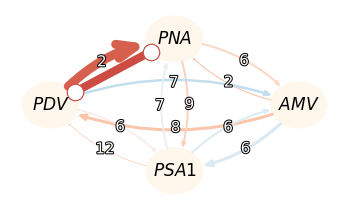

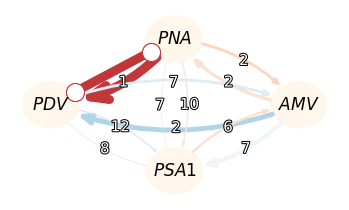

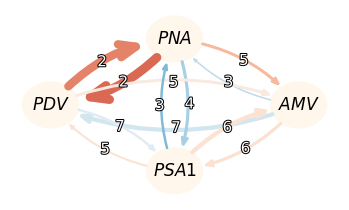

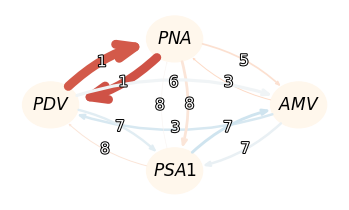

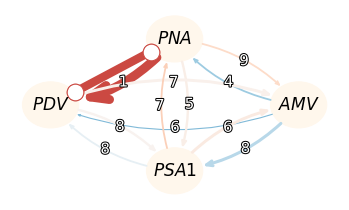

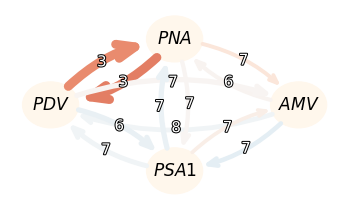

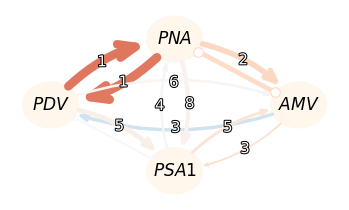

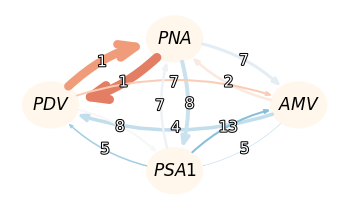

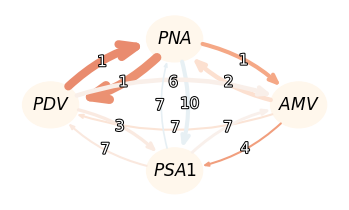

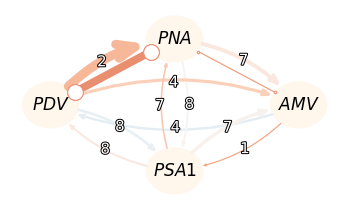

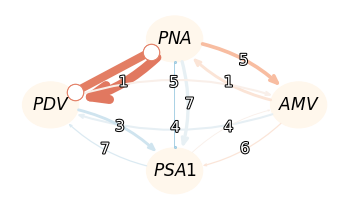

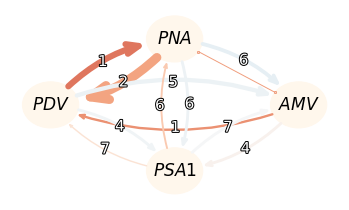

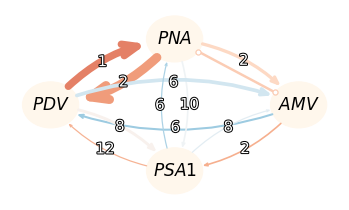

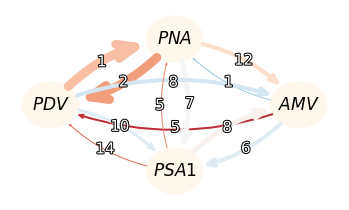

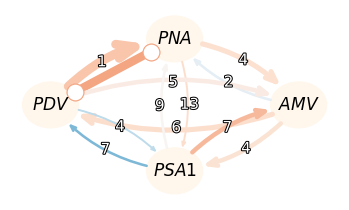

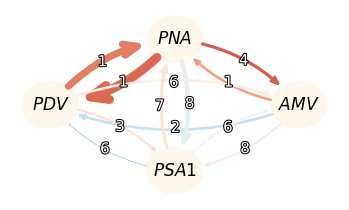

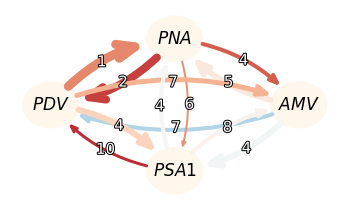

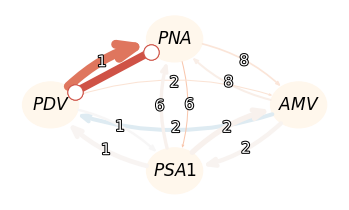

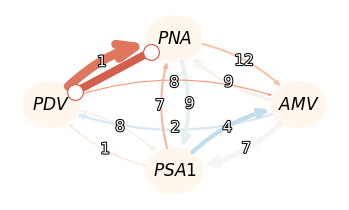

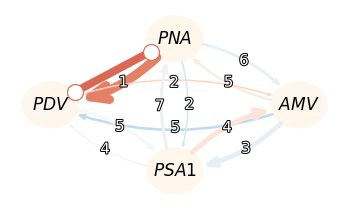

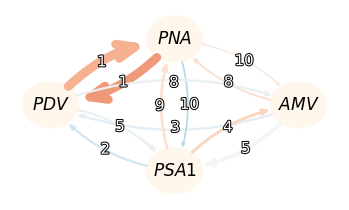

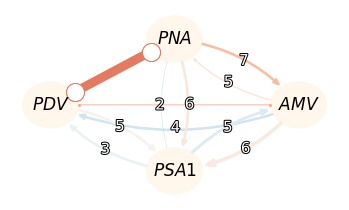

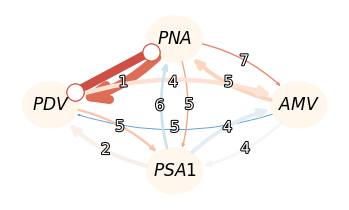

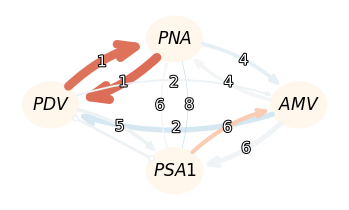

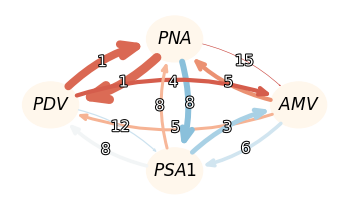

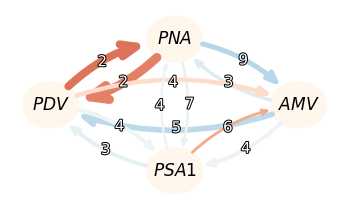

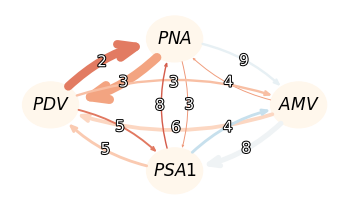

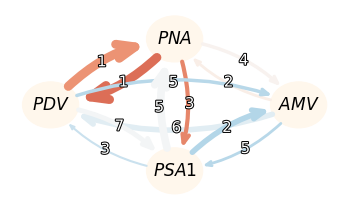

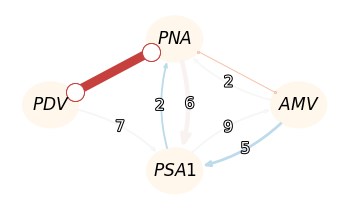

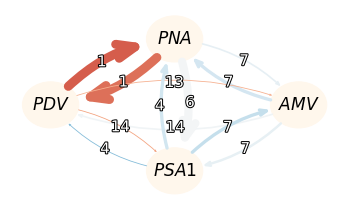

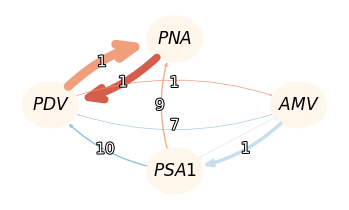

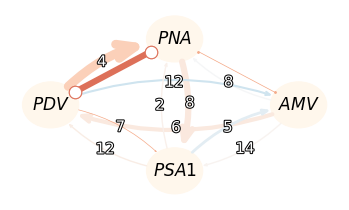

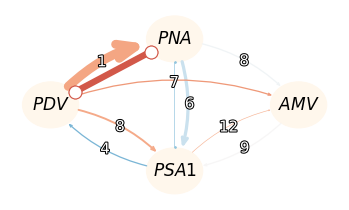

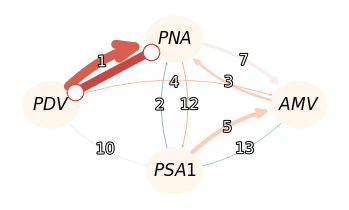

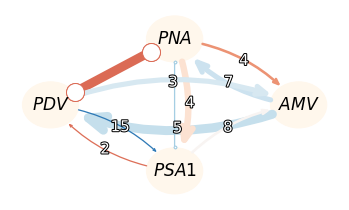

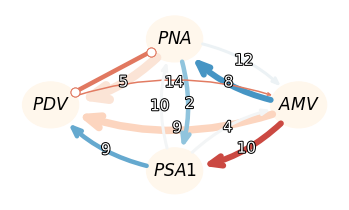

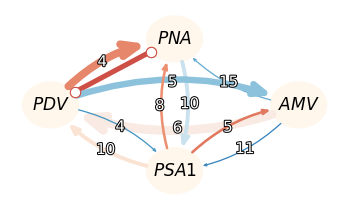

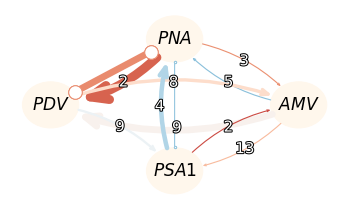

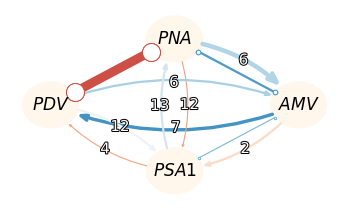

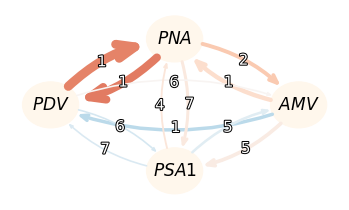

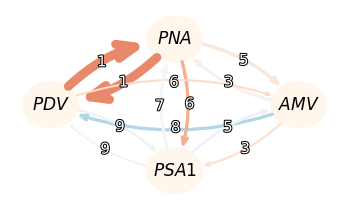

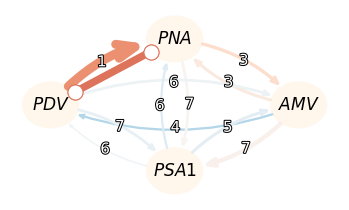

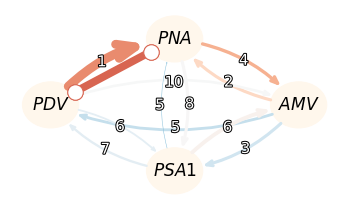

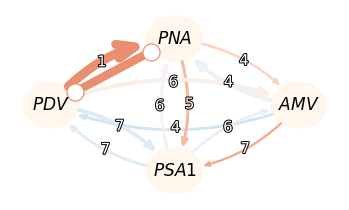

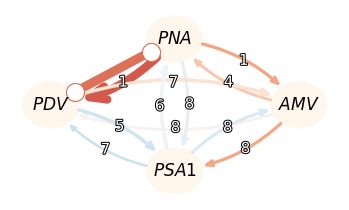

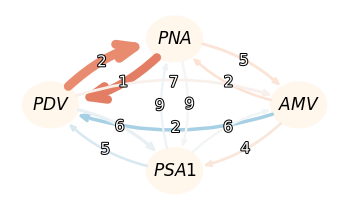

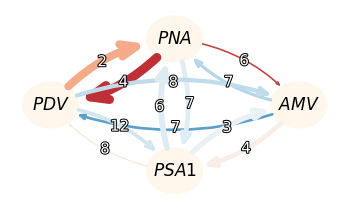

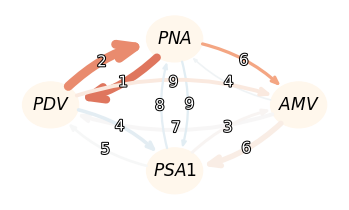

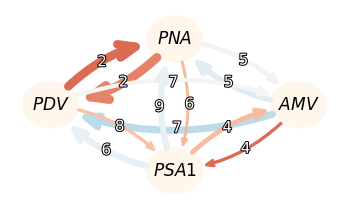

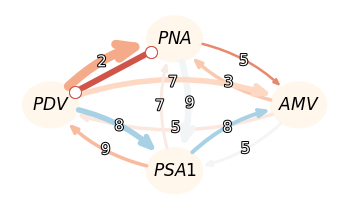

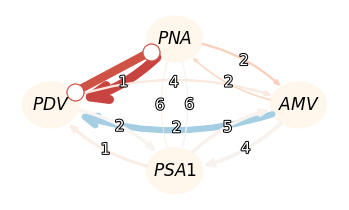

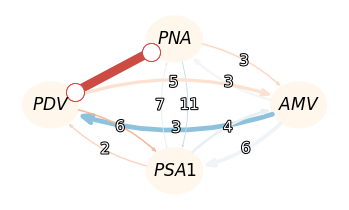

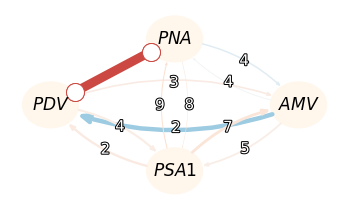

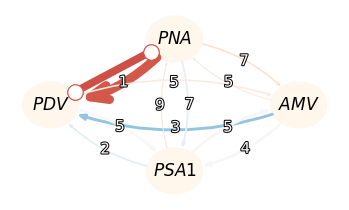

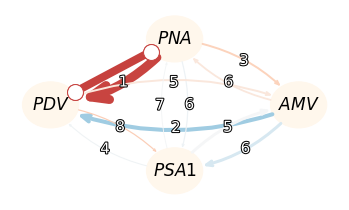

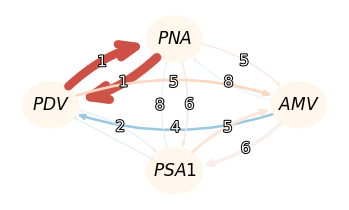

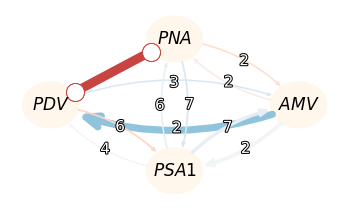

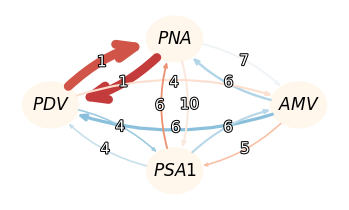

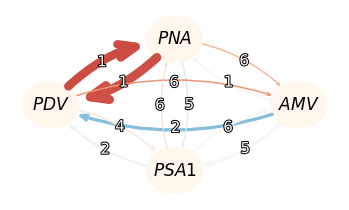

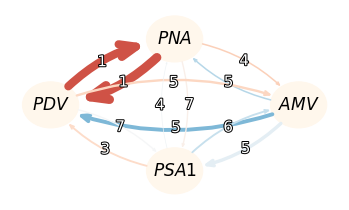

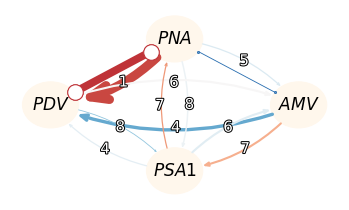

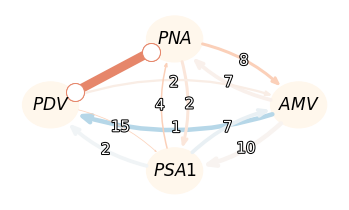

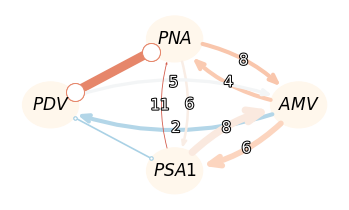

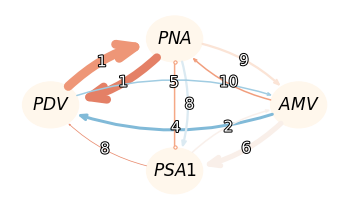

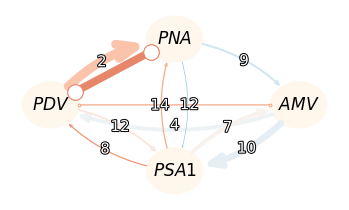

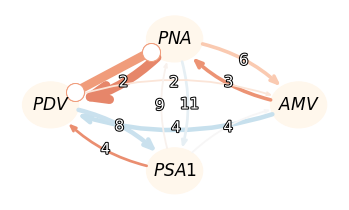

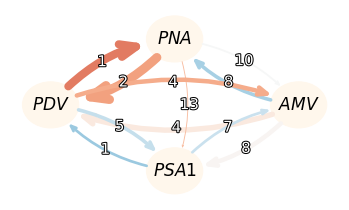

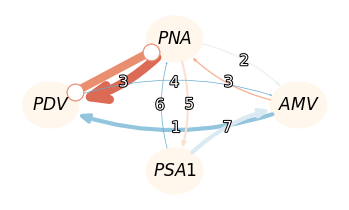

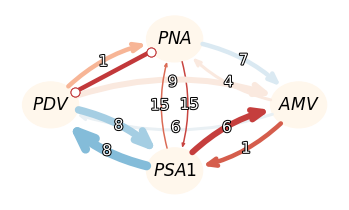

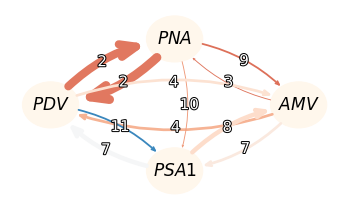

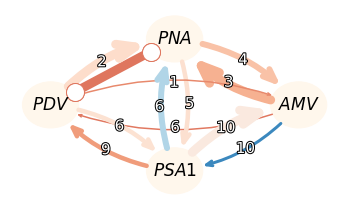

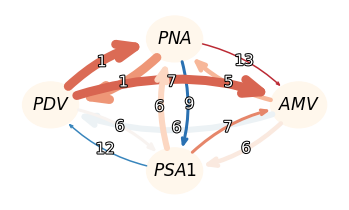

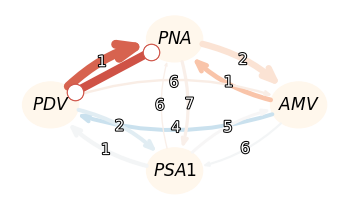

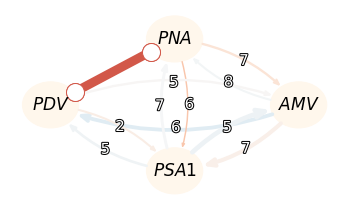

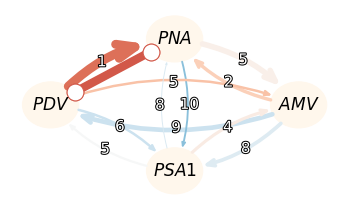

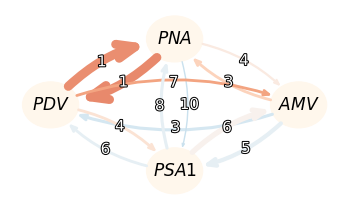

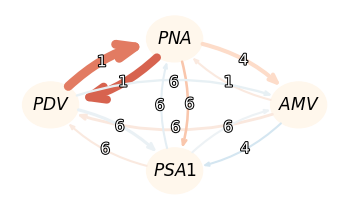

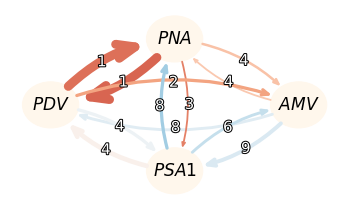

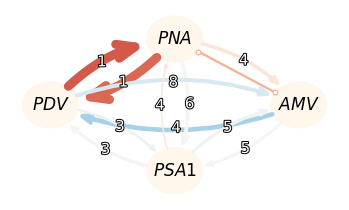

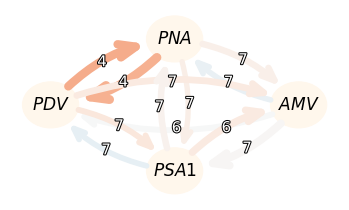

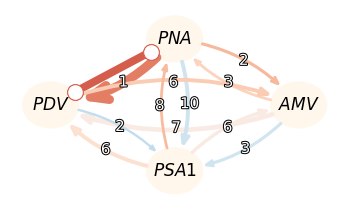

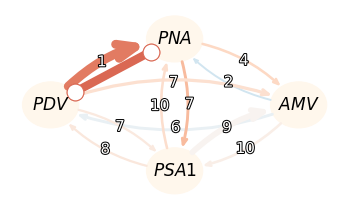

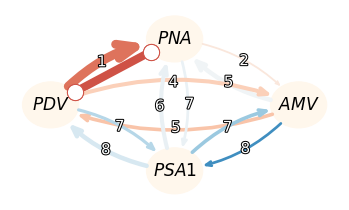

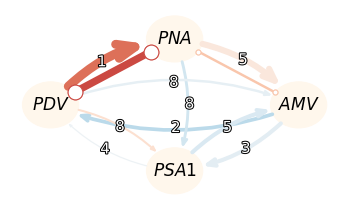

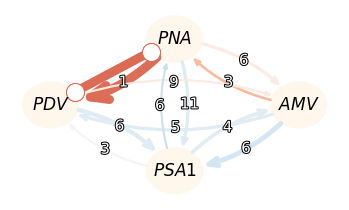

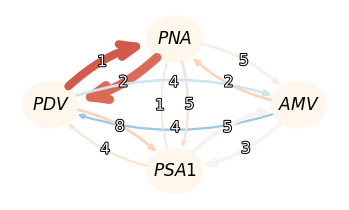

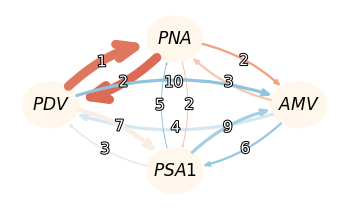

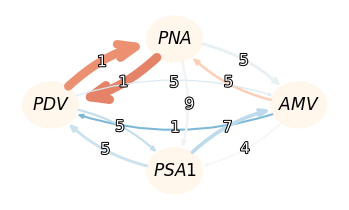

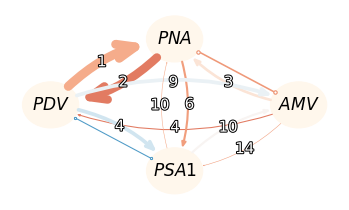

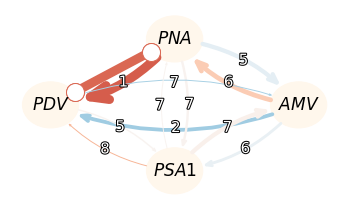

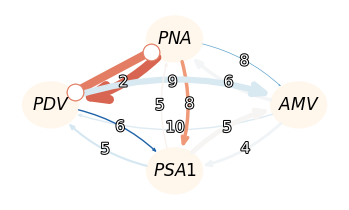

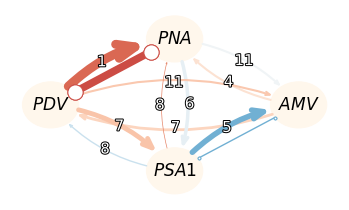

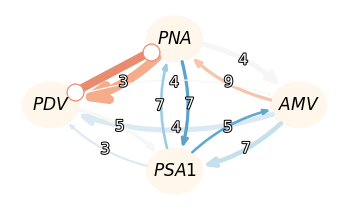

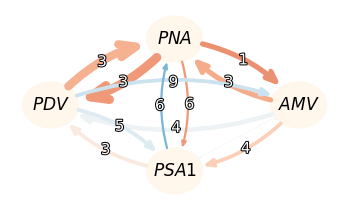

In [7]:
var_names=['$AMV$','$PNA$','$PDV$','$PSA1$']

out_dir='Results_DIR/Ensemble_causal_graphs/'

try:
    os.makedirs(out_dir)
except OSError:
    print ("Creation of the directory %s failed" % out_dir)
else:
    print ("Successfully created the directory %s" % out_dir)

for model in dict_links['No_mask'].keys():

    for regime in dict_links.keys():
        #print(regime)           
        #print(model, regime)
        tp.plot_graph(    
            val_matrix=dict_links[regime][model]['mean_val_matrix'],
            graph=dict_links[regime][model]['mean_link_matrix'],
            var_names=var_names,
            link_attribute=dict_links[regime][model]['link_width'],
            link_colorbar_label='cross-MCI (edges)',
            node_colorbar_label=regime,
            save_name=out_dir+str(model)+'_'+regime+'_summary.png',
            link_width=(dict_links[regime][model]['link_width'])*1.7,
            node_label_size=17,
            link_label_fontsize=15,
            node_size=0.7,
            arrow_linewidth=18,
            show_colorbar=False)

